---
title: Pseudospectral Differences (QG)
---

In [1]:
import autoroot
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import finitediffx as fdx
from jaxtyping import Array, Float
# from jaxsw._src.domain.base import Domain
from jaxsw._src.domain.base_v2 import Domain, init_domain_1d
import math
# from jaxsw._src.fields.base import Field
import jax.random as jrandom
from jaxsw import Field, FDField, SpectralField
from jaxsw._src.operators.functional import finitediff as F_fd
from jaxsw._src.operators.functional import spectral as F_spectral
import seaborn as sns

jax.config.update("jax_enable_x64", True)
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

### Problem Background

$$
\partial_t q + u \partial_x q + v \partial_y q = \nu \Delta q
$$

where 
* $q=\Delta\psi$ - relative vorticity
* $u=-\partial_u\psi$ - zonal velocity
* $v=\partial_x\psi$ - meridonal velocity

### Domain

In [2]:
Nx, Ny = 64, 64
Lx, Ly = 2.0*math.pi, 2.0*math.pi
dx, dy = Lx/Nx, Ly/Ny

x_domain = Domain(xmin=0, xmax=Lx-dx, dx=dx, Nx=Nx, Lx=Lx)
y_domain = Domain(xmin=0, xmax=Ly-dy, dx=dy, Nx=Ny, Lx=Ly)

xy_domain = x_domain * y_domain

In [23]:
# construct parameters
key = jrandom.PRNGKey(123)
u0: Array = jrandom.normal(key=key, shape=xy_domain.Nx)
u: Field = SpectralField(values=u0, domain=xy_domain) 

In [24]:
u.k_vec[0].shape, u.k_vec[1].shape

((64,), (64,))

In [25]:
import einops
import functools
import typing as tp


In [26]:
ksq = F_spectral.elliptical_operator_2D(u.k_vec)

# create arrays
K = einops.repeat(u.k_vec[0], "Nx -> Nx Ny", Ny=Ny)
L = einops.repeat(u.k_vec[1], "Ny -> Nx Ny", Nx=Nx)



# create inversion array
invksq = 1.0 / ksq
invksq = invksq.at[0,0].set(1.0)

In [27]:
# potential vorticity
def generate_q0(domain, seed: int=42):
    rng = np.random.RandomState(seed)
    q0 = rng.randn(*domain.Nx)
    qh0 = np.fft.fftn(q0)
    qh0 = SpectralField(values=qh0, domain=domain) 
    ksq = F_spectral.elliptical_operator_2D(qh0.k_vec)
    qh0 = qh0[:]
    qh0 = np.where(ksq > 10**2, 0.0, qh0)
    qh0 = np.where(ksq < 3**2, 0.0, qh0)
    q0 = np.real(np.fft.ifftn(qh0))
    return jnp.asarray(qh0), jnp.asarray(q0)

qh0, q0 = generate_q0(xy_domain, 42)
K = K.astype(qh0.dtype)
L = L.astype(qh0.dtype)
invksq = invksq.astype(qh0.dtype)
ksq = ksq.astype(qh0.dtype)
# stream function
psih0 = - invksq * qh0
psi0 = jnp.real(jnp.fft.ifftn(psih0))

# velocities
u0 = jnp.real(jnp.fft.ifftn(-1j * L * psih0))
v0 = jnp.real(jnp.fft.ifftn(1j * K * psih0))

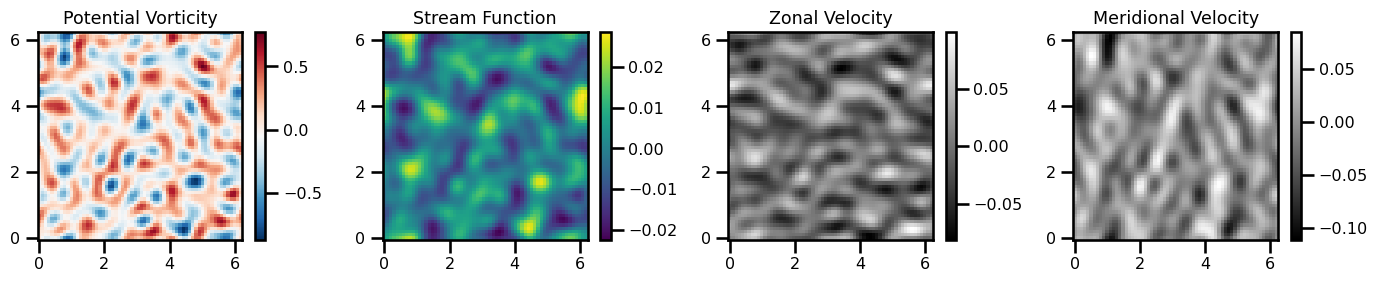

In [28]:
fig, ax = plt.subplots(ncols=4, figsize=(14,3))

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q0, cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, psi0)
ax[1].set(title="Stream Function")
plt.colorbar(pts)

pts = ax[2].pcolormesh(X, Y, u0, cmap="gray")
ax[2].set(title="Zonal Velocity")
plt.colorbar(pts)

pts = ax[3].pcolormesh(X, Y, v0, cmap="gray")
ax[3].set(title="Meridional Velocity")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [29]:


def equation_of_motion(qh: Array, nu: float) -> Array:

    # calculate psi
    psih = - invksq * qh
    
    # calculate velocities
    u = jnp.real(jnp.fft.ifftn(- 1j * L * psih))
    v = jnp.real(jnp.fft.ifftn(1j * K * psih))
    # calculate advection terms: ∂ζ/∂x | ∂ζ/∂y
    dqh_dx = jnp.real(jnp.fft.ifftn(1j * K * qh))
    dqh_dy = jnp.real(jnp.fft.ifftn(1j * L * qh))

    adv_rhs = - jnp.fft.fftn(u*dqh_dx + v*dqh_dy) 



    # calculate diffusion term
    diff_rhs = - nu * ksq * qh
    

    return adv_rhs + diff_rhs

def plot_field(u, name: str=""):

    fig, ax = plt.subplots(figsize=(4,3))

    pts = ax.pcolormesh(X, Y, np.real(u), cmap="RdBu_r")
    plt.colorbar(pts)
    ax.set(title=name)

    plt.tight_layout()
    plt.show()

complex128 complex128


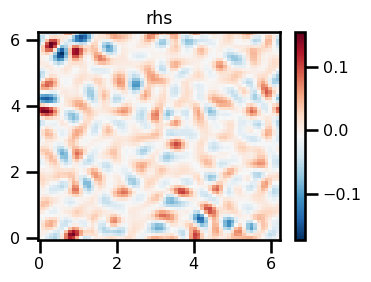

In [30]:
nu = 3.0e-04
rhs = equation_of_motion(qh0, nu)
print((rhs).dtype, (qh0).dtype)

plot_field(jnp.fft.ifftn(rhs), name="rhs")

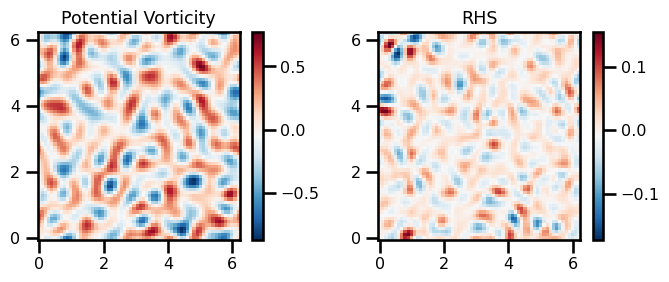

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(qh0)), cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(rhs)), cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [32]:
nu=3.0e-04

dt = 0.025
t1 = 1_000
num_steps = int(t1/dt)

ts = jnp.arange(0, t1, dt)

In [33]:
from tqdm.autonotebook import tqdm

qh0, q = generate_q0(xy_domain, 42)

qh = jnp.copy(qh0)

fn = jax.jit(equation_of_motion, static_argnames="nu")

for i in tqdm(ts):

    rhs = fn(qh, nu)

    qh = qh + dt*rhs
    

    

  0%|          | 0/40000 [00:00<?, ?it/s]

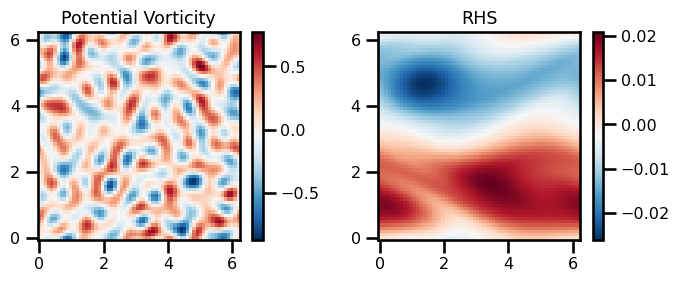

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(qh0)), cmap="RdBu_r")
ax[0].set(title="Potential Vorticity")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, jnp.real(jnp.fft.ifftn(qh)), cmap="RdBu_r")
ax[1].set(title="RHS")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [35]:
# stream function
psih = - invksq * qh
psi = jnp.real(jnp.fft.ifftn(psih))

# velocities
u = jnp.real(jnp.fft.ifftn(-1j * L * psih))
v = jnp.real(jnp.fft.ifftn(1j * K * psih))

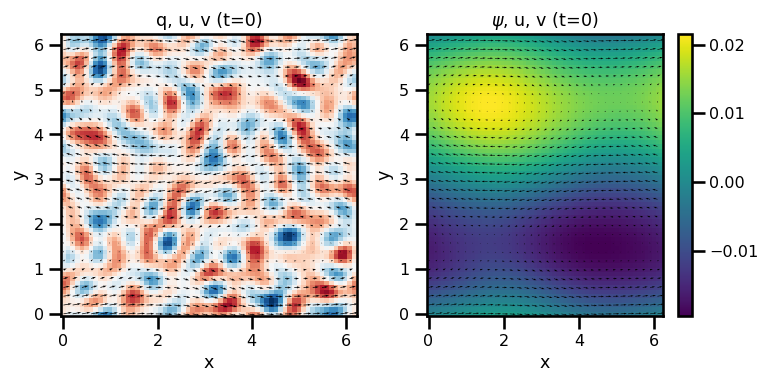

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

nc = int(Nx/32)

X, Y = xy_domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q[:], cmap="RdBu_r")
ax[0].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[0].set(xlabel="x", ylabel="y", title="q, u, v (t=0)")

pts = ax[1].pcolormesh(X, Y, psi[:], cmap="viridis")
ax[1].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[1].set(xlabel="x", ylabel="y", title="$\psi$, u, v (t=0)")


plt.colorbar(pts)

plt.tight_layout()
plt.show()

### Diffrax Integration Scheme

In [37]:
def equation_of_motion_real(q: Array, nu: float) -> Array:

    qh = jnp.fft.fftn(q)

    # calculate psi
    psih = - invksq * qh
    
    # calculate velocities
    u = jnp.real(jnp.fft.ifftn(- 1j * L * psih))
    v = jnp.real(jnp.fft.ifftn(1j * K * psih))
    # calculate advection terms: ∂ζ/∂x | ∂ζ/∂y
    dqh_dx = jnp.real(jnp.fft.ifftn(1j * K * qh))
    dqh_dy = jnp.real(jnp.fft.ifftn(1j * L * qh))

    adv_rhs = - jnp.fft.fftn(u*dqh_dx + v*dqh_dy) 

    # calculate diffusion term
    diff_rhs = - nu * ksq * qh

    rhs = adv_rhs + diff_rhs

    rhs = jnp.real(jnp.fft.ifftn(rhs))

    return rhs

In [38]:
import diffrax as dfx

In [39]:
# Euler, Constant StepSize
# solver = dfx.Euler()
# stepsize_controller = dfx.ConstantStepSize()

solver = dfx.Dopri5()
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)

In [40]:
t0, t1 = 0.0, 1_000.0 #1_000.0
t_save = np.linspace(t0, t1, 100)
saveat = dfx.SaveAt(ts=t_save)

In [41]:
class State(tp.NamedTuple):
    q: Array

def vector_field(t, state: State, args) -> State:
    nu = args
    q = state.q
    rhs = equation_of_motion_real(q=q, nu=nu)
    return State(q=rhs)

In [42]:
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=State(q=q0),
    saveat=saveat,
    args=nu,
    stepsize_controller=stepsize_controller,
    # max_steps=
)

In [43]:
# sol.ys

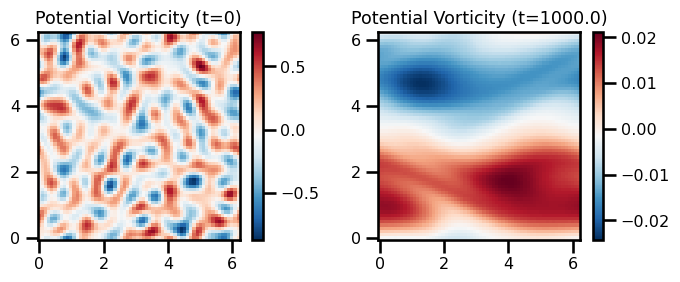

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis
q = sol.ys.q[-1]


pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].set(title="Potential Vorticity (t=0)")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, q[:], cmap="RdBu_r")
ax[1].set(title=f"Potential Vorticity (t={t1})")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [45]:
q = SpectralField(q, xy_domain)
psi = F_spectral.elliptical_inversion_2D(q)
u = - F_spectral.difference_field(psi, axis=1, derivative=1, real=True)
v = F_spectral.difference_field(psi, axis=0, derivative=1, real=True)

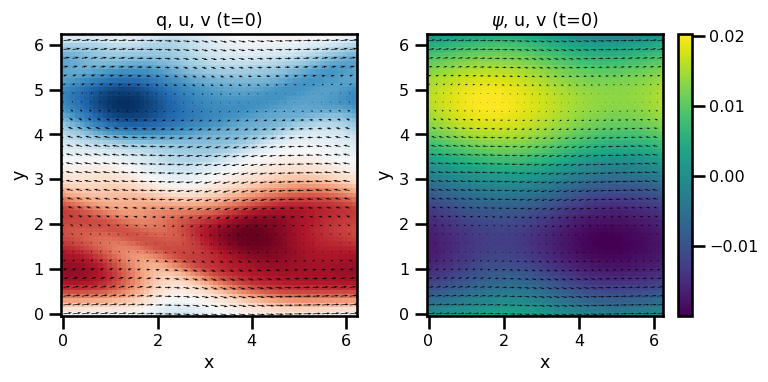

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))

nc = int(Nx/32)

X, Y = q.domain.grid_axis

pts = ax[0].pcolormesh(X, Y, q[:], cmap="RdBu_r")
ax[0].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[0].set(xlabel="x", ylabel="y", title="q, u, v (t=0)")

pts = ax[1].pcolormesh(X, Y, psi[:], cmap="viridis")
ax[1].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[1].set(xlabel="x", ylabel="y", title="$\psi$, u, v (t=0)")


plt.colorbar(pts)

plt.tight_layout()
plt.show()

### REFACTORED

In [47]:
Nx, Ny = 64, 64
Lx, Ly = 2.0*math.pi, 2.0*math.pi
dx, dy = Lx/Nx, Ly/Ny

x_domain = Domain(xmin=0, xmax=Lx-dx, dx=dx, Nx=Nx, Lx=Lx)
y_domain = Domain(xmin=0, xmax=Ly-dy, dx=dy, Nx=Ny, Lx=Ly)

xy_domain = x_domain * y_domain



In [48]:
qh0, q0 = generate_q0(xy_domain, 42)

In [49]:
class Params(eqx.Module):
    nu: float = eqx.static_field() # viscosity coefficient
    mu: float = eqx.static_field() # linear drag
    beta: float = eqx.static_field() # Planetary vorticity y-gradient
    nv: int = eqx.static_field() # hyperviscous order

l_unit = 5_040e3 / math.pi
t_unit = 1.2e6

params = Params(
    nu=3.0e-04, # 352 / l_unit**2 / t_unit
    mu=0.0, #1.24e-8 / t_unit**(-1),
    beta=0.0, #0.5,
    nv=1, # hyperviscous order
)
params

Params(nu=0.0003, mu=0.0, beta=0.0, nv=1)

In [50]:
from jaxsw._src.operators.constant import Constant

def equation_of_motion_field(q: Field, params: Params) -> Array:

    # ==============================
    # calculate psi (Elliptical inversion)
    # ----------------
    # q = ∇²ψ
    # q̂ = (|k|² + 1/ℓ²)ψ̂
    # ψ̂ = q / (|k|² + 1/ℓ²)
    # ==============================
    psi = F_spectral.elliptical_inversion_2D(q)

    # ###############################
    # Advection Term
    # ----------------
    # ∇⋅(uq) = u ∂x q + v ∂y q
    #        = u ikx q̂ + iky q̂
    # where
    #  u = - ∂yψ = - iky ψ̂
    #  v =   ∂xψ =   ikx ψ̂
    # ###############################
    
    # calculate velocities
    u = - F_spectral.difference_field(psi, axis=1)
    v = F_spectral.difference_field(psi, axis=0)
    
    # calculate advection terms: ∂ζ/∂x | ∂ζ/∂y
    dqh_dx = F_spectral.difference_field(q, axis=0)
    dqh_dy = F_spectral.difference_field(q, axis=1)

    rhs = - (u * dqh_dx + v * dqh_dy) 

    # ###############################
    # Linear Terms
    # ###############################

    # ==============================
    # bottom drag
    # -----------
    # − μ q 
    # ==============================
    if params.mu > 0.0:
        rhs += - Constant(params.mu) * q

    # ===================================
    # (hyper-) viscosity term
    # -----------------------
    # - ν|k|²ⁿ q
    # ===================================
    if params.nu > 0.0:
        rhs += - Constant(params.nu) * F_spectral.laplacian_field(q, order=params.nv)
    # ===================================
    # beta plane term
    # ---------------
    # - ∂xψ = - iβkx ψ̂ 
    #       = - β (ikx ψ̂) 
    #       = - β v
    # =======================================
    if params.beta > 0.0:
        rhs += - Constant(params.beta) * v

    return rhs

In [51]:
# # Euler, Constant StepSize
# solver = dfx.Euler()
# stepsize_controller = dfx.ConstantStepSize()

solver = dfx.Dopri5()
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)

In [52]:
t0, t1 = 0.0, 1_000.0 #1_000.0
t_save = np.linspace(t0, t1, 100)
saveat = dfx.SaveAt(ts=t_save)

In [53]:
class State(tp.NamedTuple):
    q: Field

def vector_field(t, state: State, args) -> State:
    params = args
    q = state.q
    rhs = equation_of_motion_field(q=q, params=params)
    return State(q=rhs)


In [54]:
%%time

# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=State(q=SpectralField(q0, xy_domain)),
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
    # max_steps=
)

CPU times: user 1.16 s, sys: 39.9 ms, total: 1.2 s
Wall time: 1.19 s


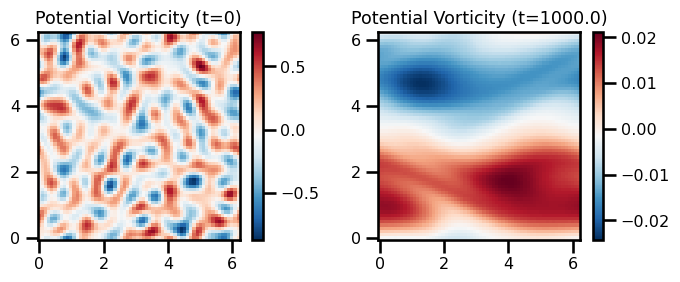

In [55]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

X, Y = xy_domain.grid_axis
q_plot = sol.ys.q[-1]


pts = ax[0].pcolormesh(X, Y, q0[:], cmap="RdBu_r")
ax[0].set(title="Potential Vorticity (t=0)")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, q_plot[:], cmap="RdBu_r")
ax[1].set(title=f"Potential Vorticity (t={t1})")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [56]:
# q = SpectralField(q, xy_domain)
psi = F_spectral.elliptical_inversion_2D(SpectralField(sol.ys.q[-1], xy_domain))
u = - F_spectral.difference_field(psi, axis=1, derivative=1, real=True)
v = F_spectral.difference_field(psi, axis=0, derivative=1, real=True)

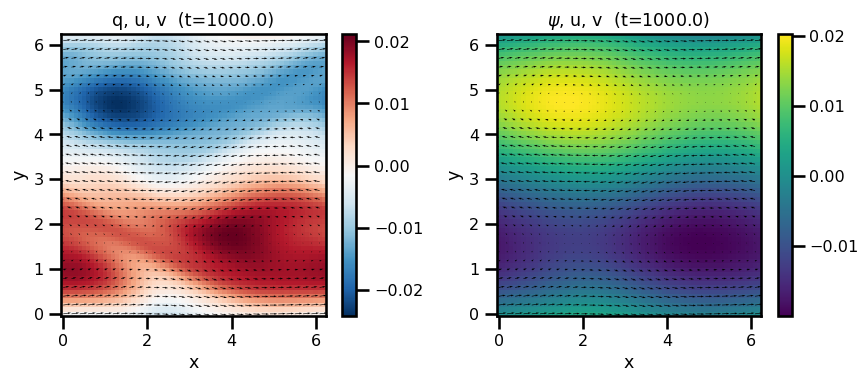

In [57]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))

nc = int(Nx/32)

X, Y = sol.ys.q.domain.grid_axis
# q_plot = sol.ys.q[-2]

pts = ax[0].pcolormesh(X, Y, sol.ys.q[-1][:], cmap="RdBu_r")
ax[0].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[0].set(xlabel="x", ylabel="y", title=f"q, u, v  (t={t1})")
plt.colorbar(pts)

pts = ax[1].pcolormesh(X, Y, psi[:], cmap="viridis")
ax[1].quiver(X[::nc,::nc], Y[::nc,::nc], u[::nc,::nc], v[::nc,::nc])
ax[1].set(xlabel="x", ylabel="y", title=f"$\psi$, u, v  (t={t1})")

plt.colorbar(pts)

plt.tight_layout()
plt.show()